In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [5]:
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '37-resnet152'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_PATH = f'{COLAB_BASE_PATH}Submissions/{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = f'{COLAB_BASE_PATH}Submissions/{MODEL_NAME}_last.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [6]:
# !pip install --quiet efficientnet
!pip install --quiet image-classifiers

In [7]:
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
# import efficientnet.tfkeras as efn
from classification_models.tfkeras import Classifiers

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## TPU configuration

In [8]:
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

Running on TPU  grpc://10.82.13.130:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# Model parameters

In [9]:
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 512,
  "EPOCHS": 50,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "BASE_MODEL": 'resnet152',
  "BASE_MODEL_WEIGHTS": 'imagenet11k',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'resnet152',
 'BASE_MODEL_WEIGHTS': 'imagenet11k',
 'BATCH_SIZE': 512,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 50,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'WIDTH': 256}

# Load data

In [10]:
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-e12fcdd8602eaeb3e7343f4b322f78239cfa17e4bf5db65058b851ad' # KaggleDatasets().get_gcs_path(config['DATASET_PATH'])
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')
GCS_PATH_EXT = 'gs://kds-c2f318ab381f072971d2adb35fbd1cf6f734c11ee731b63b7915ac3e'
TRAINING_FILENAMES_EXT = tf.io.gfile.glob(GCS_PATH_EXT + '/train*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [11]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .7: # random rotation range 0º to 45º
        image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'])
        
    if p_crop >= .6: # crops
        if p_crop >= .95:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.7), int(config['WIDTH']*.7), config['CHANNELS']])
        elif p_crop >= .85:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.6)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    return image, label

## Auxiliary functions

In [12]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = 45. * tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1] ,dtype='float32')
    zero = tf.constant([0], dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0), [3, 3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM, 3])

## Learning rate scheduler

Learning rate schedule: 0 to 0.000295 to 2.3e-05


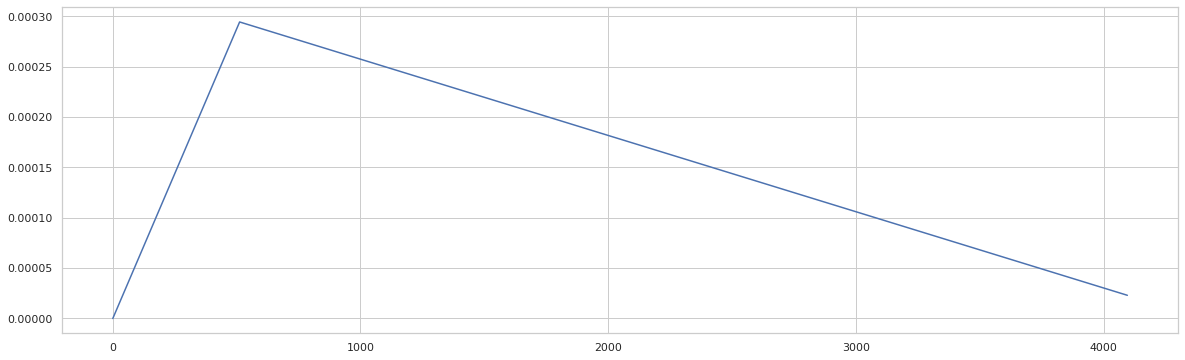

In [ ]:
lr_min = 1e-6
lr_start = 0
lr_max = config['LEARNING_RATE']
step_size = 45365 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * step_size
hold_max_steps = 0
warmup_steps = step_size * 5

rng = [i for i in range(0, total_steps, config['BATCH_SIZE'])]
y = [linear_schedule_with_warmup(tf.cast(x, tf.float32), total_steps=total_steps, 
                                 warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                                 lr_start=lr_start, lr_max=lr_max, lr_min=lr_min) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [13]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    BaseModel, preprocess_input = Classifiers.get(config['BASE_MODEL'])
    base_model = BaseModel(input_shape=input_shape, 
                           weights=config['BASE_MODEL_WEIGHTS'], 
                           include_top=False)

    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    output = L.Dense(1, activation='sigmoid')(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [ ]:
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(len(k_fold)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)

history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

# Get original dataset validation indexes
val_idx_eval = []
for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
  val_idx_eval.append(val_idx)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES_EXT)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES_EXT)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES_EXT)[val_idx]
        train_size = count_data_items(train_filenames)

        step_size = train_size // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_loss', mode='min', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_loss', mode='min', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: linear_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                     total_steps=total_steps, warmup_steps=warmup_steps, 
                                                     hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                     lr_max=lr_max, lr_min=lr_min)

            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(label_smoothing=0.05), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=step_size,
                            callbacks=[checkpoint, es], 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Make predictions (last model)
        preds = model.predict(image_data)
        name_preds = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds[x['image_name']], axis=1)

        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx_eval[n_fold-1]]
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)

        # Make predictions (best model)
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds[x['image_name']], axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/50
93/93 - 101s - loss: 0.3915 - auc: 0.7729 - val_loss: 0.4874 - val_auc: 0.4656
Epoch 2/50
93/93 - 67s - loss: 0.2668 - auc: 0.8940 - val_loss: 1.1055 - val_auc: 0.6739
Epoch 3/50
93/93 - 67s - loss: 0.2561 - auc: 0.9105 - val_loss: 0.5096 - val_auc: 0.5404
Epoch 4/50
93/93 - 67s - loss: 0.2511 - auc: 0.9166 - val_loss: 0.7609 - val_auc: 0.5000
Epoch 5/50
93/93 - 73s - loss: 0.2506 - auc: 0.9182 - val_loss: 0.3568 - val_auc: 0.4347
Epoch 6/50
93/93 - 75s - loss: 0.2472 - auc: 0.9222 - val_loss: 0.3543 - val_auc: 0.6488
Epoch 7/50
93/93 - 75s - loss: 0.2409 - auc: 0.9312 - val_loss: 0.3498 - val_auc: 0.5141
Epoch 8/50
93/93 - 67s - loss: 0.2350 - auc: 0.9362 - val_loss: 0.3580 - val_auc: 0.6678
Epoch 9/50
93/93 - 74s - loss: 0.2338 - auc: 0.9374 - val_loss: 0.3312 - val_auc: 0.7139
Epoch 10/50
93/93 - 68s - loss: 0.2295 - auc: 0.9427 - val_loss: 0.3486 - val_auc: 0.7465
Epoch 11/50
93/93 - 67s - loss: 0.2256 - auc: 0.9479 - val_loss: 0.4270 - val_auc: 0.8606
Epoch 12/50
93/93 

INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/50
93/93 - 96s - loss: 0.3926 - auc: 0.7745 - val_loss: 0.5854 - val_auc: 0.5730
Epoch 2/50
93/93 - 74s - loss: 0.2671 - auc: 0.8918 - val_loss: 0.3634 - val_auc: 0.5182
Epoch 3/50
93/93 - 67s - loss: 0.2567 - auc: 0.9082 - val_loss: 0.3711 - val_auc: 0.3694
Epoch 4/50
93/93 - 68s - loss: 0.2497 - auc: 0.9193 - val_loss: 0.3697 - val_auc: 0.4816
Epoch 5/50
93/93 - 68s - loss: 0.2476 - auc: 0.9217 - val_loss: 0.3667 - val_auc: 0.5155
Epoch 6/50
93/93 - 68s - loss: 0.2449 - auc: 0.9237 - val_loss: 0.3802 - val_auc: 0.4572
Epoch 7/50
93/93 - 68s - loss: 0.2394 - auc: 0.9303 - val_loss: 0.4124 - val_auc: 0.5811
Epoch 8/50
93/93 - 68s - loss: 0.2366 - auc: 0.9349 - val_loss: 0.6131 - val_auc: 0.5542
Epoch 9/50
93/93 - 68s - loss: 0.2303 - auc: 0.9412 - val_loss: 0.4008 - val_auc: 0.7083
Epoch 10/50
93/93 - 68s - loss: 0.2313 - auc: 0.9397 - val_loss: 0.4623 - val_auc: 0.7988
Epoch 11/50
93/93 - 68s - loss: 0.2267 - auc: 0.9448 - val_loss: 0.3652 - val_auc: 0.8320
Epoch 12/50
93/93 -

INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/50
97/97 - 99s - loss: 0.3604 - auc: 0.7970 - val_loss: 0.5118 - val_auc: 0.5047
Epoch 2/50
97/97 - 70s - loss: 0.2631 - auc: 0.8992 - val_loss: 0.8151 - val_auc: 0.5000
Epoch 3/50
97/97 - 77s - loss: 0.2547 - auc: 0.9113 - val_loss: 0.4631 - val_auc: 0.4900
Epoch 4/50
97/97 - 70s - loss: 0.2506 - auc: 0.9154 - val_loss: 0.4859 - val_auc: 0.4809
Epoch 5/50
97/97 - 76s - loss: 0.2483 - auc: 0.9202 - val_loss: 0.3491 - val_auc: 0.6677
Epoch 6/50
97/97 - 70s - loss: 0.2430 - auc: 0.9268 - val_loss: 0.3660 - val_auc: 0.5044
Epoch 7/50
97/97 - 70s - loss: 0.2385 - auc: 0.9318 - val_loss: 0.3498 - val_auc: 0.5937
Epoch 8/50
97/97 - 70s - loss: 0.2366 - auc: 0.9339 - val_loss: 0.3551 - val_auc: 0.6482
Epoch 9/50
97/97 - 70s - loss: 0.2325 - auc: 0.9383 - val_loss: 0.4296 - val_auc: 0.7822
Epoch 10/50
97/97 - 76s - loss: 0.2293 - auc: 0.9417 - val_loss: 0.3007 - val_auc: 0.8207
Epoch 11/50
97/97 - 70s - loss: 0.2276 - auc: 0.9434 - val_loss: 0.4940 - val_auc: 0.7213
Epoch 12/50
97/97 -

INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/50
93/93 - 100s - loss: 0.5203 - auc: 0.7460 - val_loss: 5.0577 - val_auc: 0.4983
Epoch 2/50
93/93 - 76s - loss: 0.2641 - auc: 0.9007 - val_loss: 0.9477 - val_auc: 0.5749
Epoch 3/50
93/93 - 74s - loss: 0.2529 - auc: 0.9169 - val_loss: 0.3625 - val_auc: 0.6666
Epoch 4/50
93/93 - 68s - loss: 0.2489 - auc: 0.9191 - val_loss: 0.6073 - val_auc: 0.5179
Epoch 5/50
93/93 - 68s - loss: 0.2516 - auc: 0.9174 - val_loss: 0.5514 - val_auc: 0.5009
Epoch 6/50
93/93 - 68s - loss: 0.2448 - auc: 0.9262 - val_loss: 0.4184 - val_auc: 0.6880
Epoch 7/50
93/93 - 68s - loss: 0.2400 - auc: 0.9316 - val_loss: 0.4422 - val_auc: 0.5638
Epoch 8/50
93/93 - 68s - loss: 0.2371 - auc: 0.9367 - val_loss: 0.4681 - val_auc: 0.6346
Epoch 9/50
93/93 - 74s - loss: 0.2311 - auc: 0.9427 - val_loss: 0.3367 - val_auc: 0.6976
Epoch 10/50
93/93 - 68s - loss: 0.2279 - auc: 0.9444 - val_loss: 0.4627 - val_auc: 0.6433
Epoch 11/50
93/93 - 68s - loss: 0.2266 - auc: 0.9463 - val_loss: 0.3582 - val_auc: 0.7928
Epoch 12/50
93/93 

INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.82.13.130:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/50
93/93 - 96s - loss: 0.3241 - auc: 0.8135 - val_loss: 0.3507 - val_auc: 0.5238
Epoch 2/50
93/93 - 67s - loss: 0.2655 - auc: 0.8966 - val_loss: 0.4054 - val_auc: 0.4925
Epoch 3/50
93/93 - 74s - loss: 0.2564 - auc: 0.9103 - val_loss: 0.3506 - val_auc: 0.5294
Epoch 4/50
93/93 - 68s - loss: 0.2551 - auc: 0.9123 - val_loss: 0.5272 - val_auc: 0.5032
Epoch 5/50
93/93 - 68s - loss: 0.2526 - auc: 0.9169 - val_loss: 0.7590 - val_auc: 0.3350
Epoch 6/50
93/93 - 74s - loss: 0.2455 - auc: 0.9246 - val_loss: 0.3484 - val_auc: 0.6166
Epoch 7/50
93/93 - 74s - loss: 0.2437 - auc: 0.9273 - val_loss: 0.3300 - val_auc: 0.7041
Epoch 8/50
93/93 - 67s - loss: 0.2392 - auc: 0.9331 - val_loss: 0.3966 - val_auc: 0.6604
Epoch 9/50
93/93 - 68s - loss: 0.2349 - auc: 0.9373 - val_loss: 0.5004 - val_auc: 0.6358
Epoch 10/50
93/93 - 68s - loss: 0.2337 - auc: 0.9396 - val_loss: 0.4208 - val_auc: 0.7538
Epoch 11/50
93/93 - 68s - loss: 0.2288 - auc: 0.9433 - val_loss: 0.5826 - val_auc: 0.6946
Epoch 12/50
93/93 -

## Model loss graph

Fold: 1


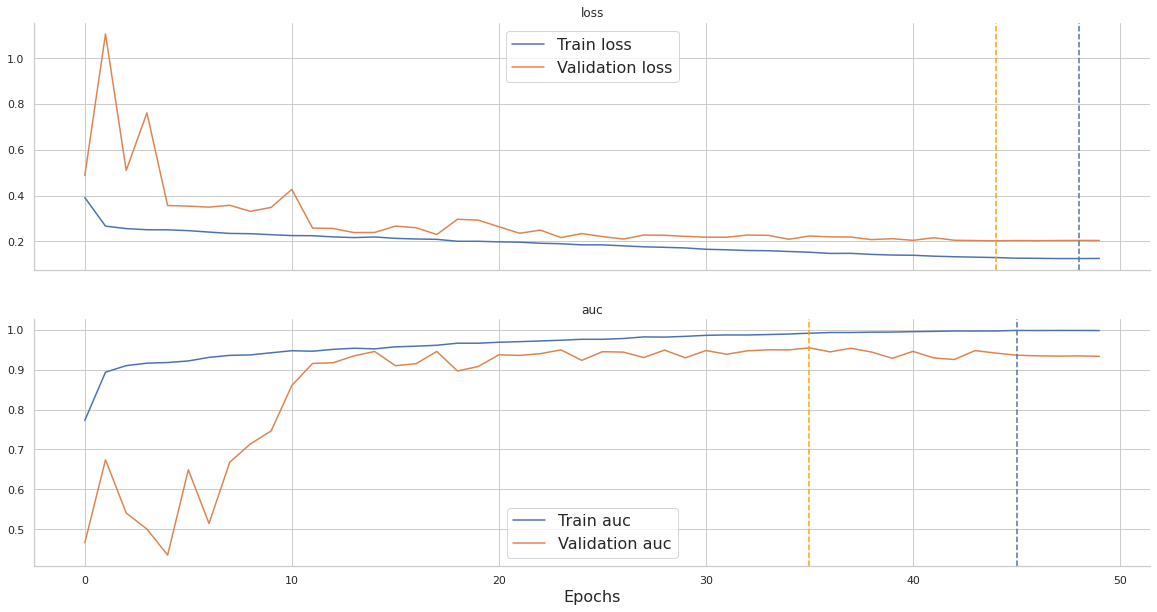

Fold: 2


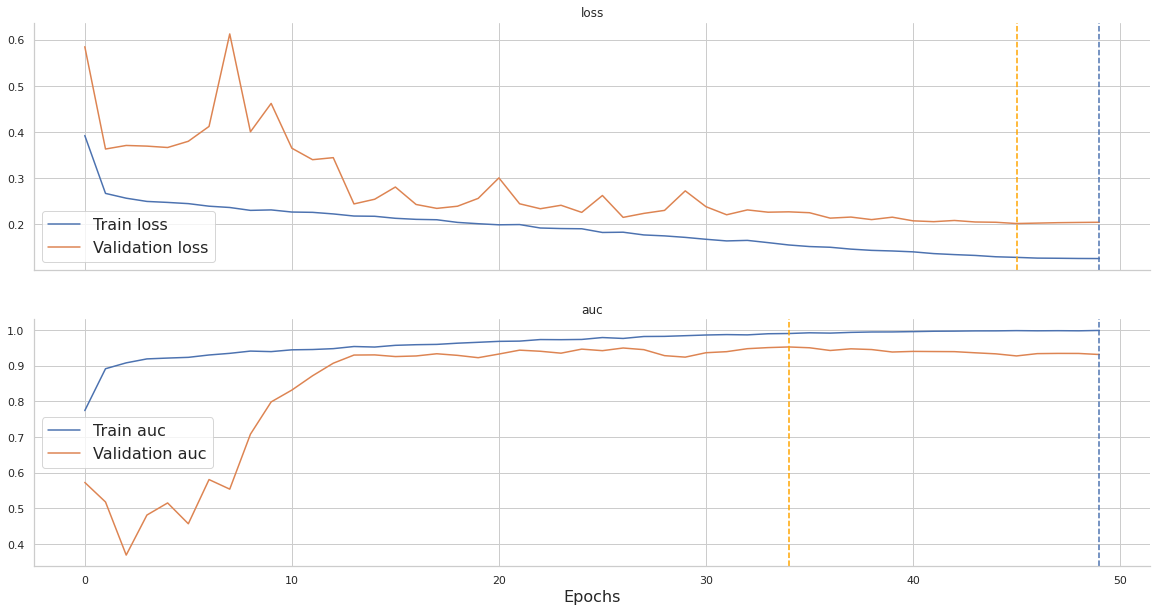

Fold: 3


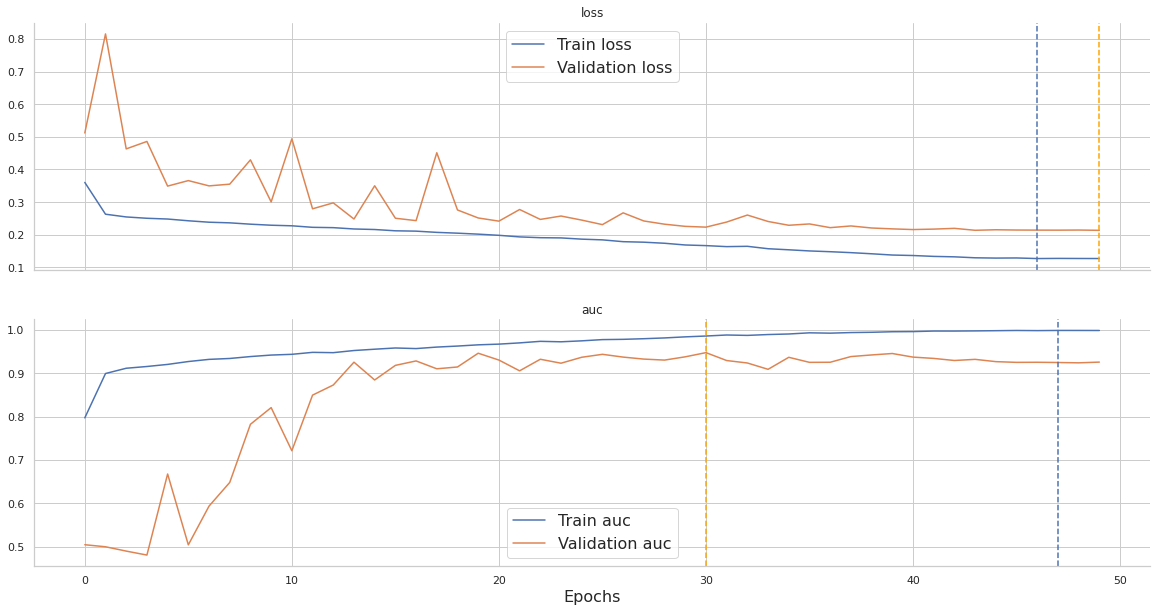

Fold: 4


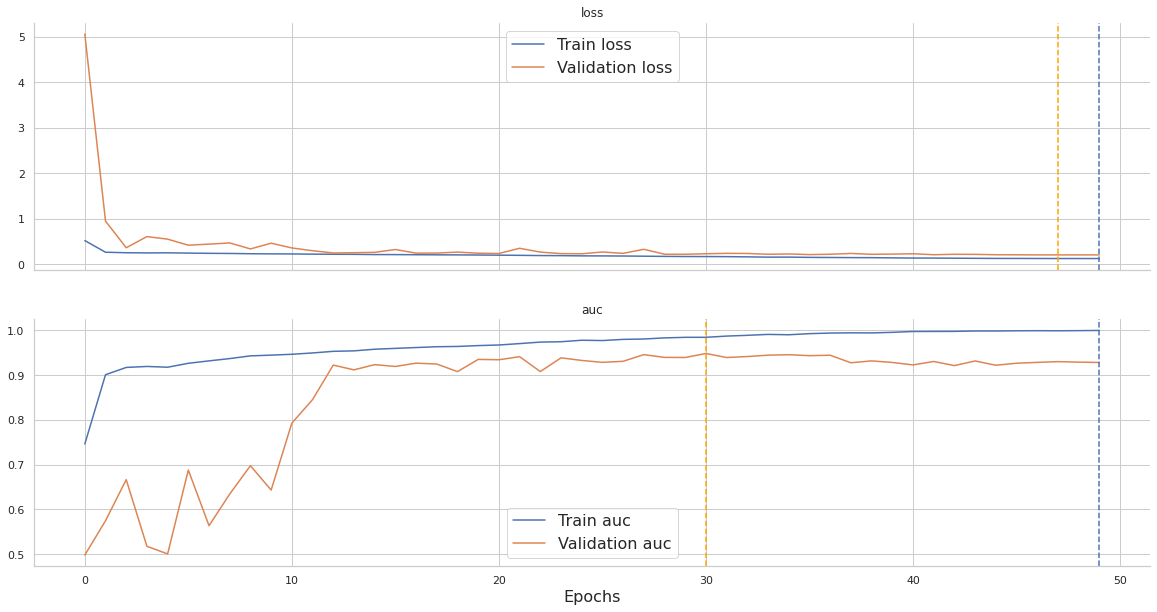

Fold: 5


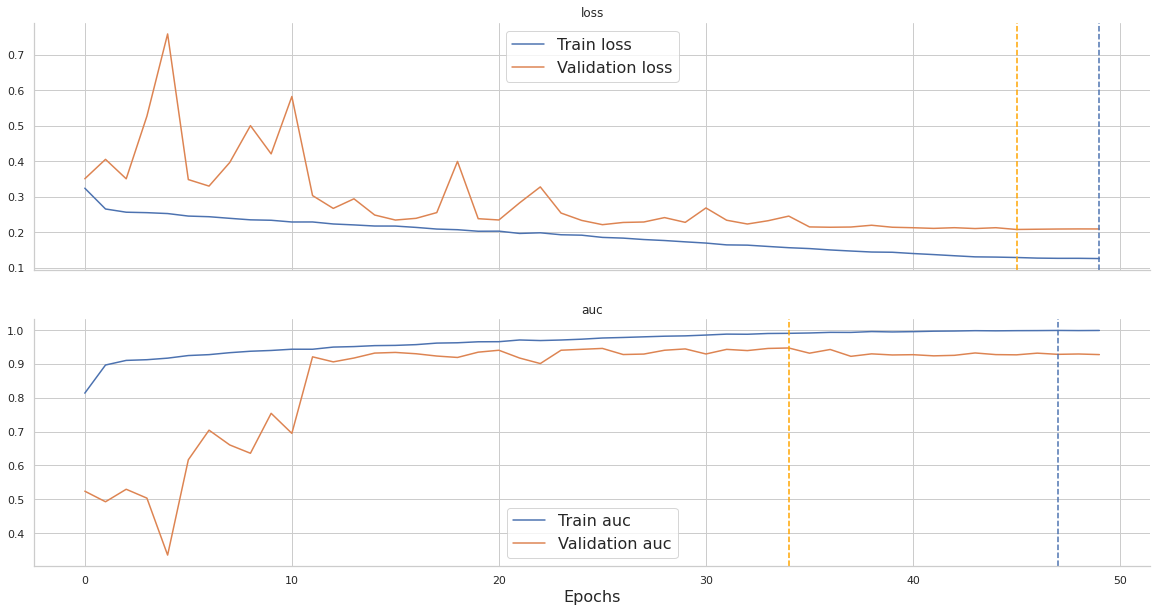

In [ ]:
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

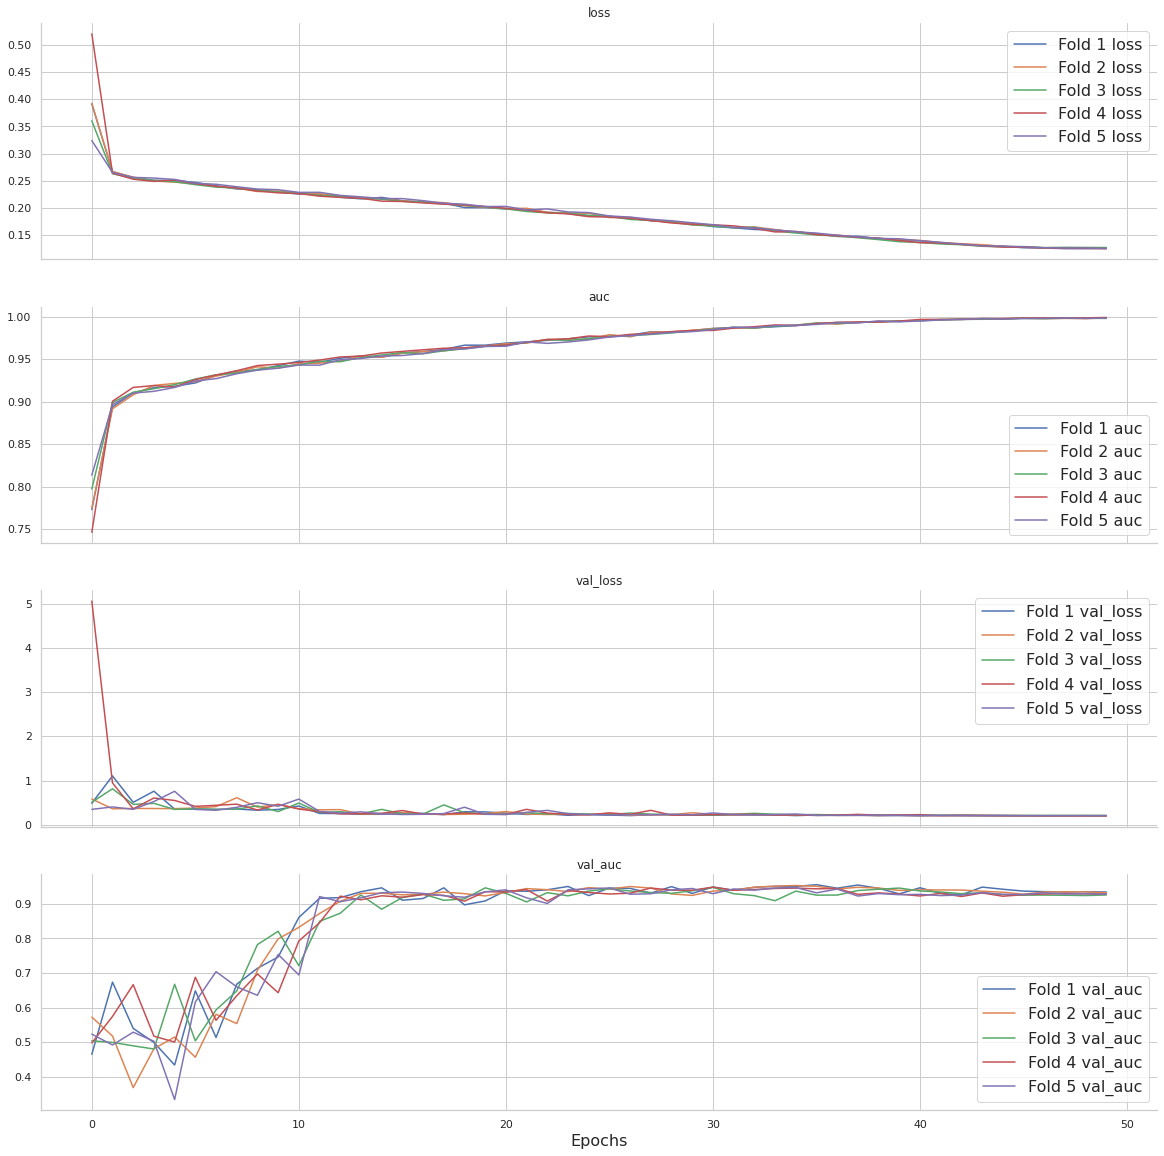

In [ ]:
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation

In [ ]:
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.948843,0.947044,0.001799,0.956453,0.924232,0.944534,0.944608,0.944534,0.970590,0.953219,0.927336,0.945474,0.968450
Accuracy,0.993829,0.993834,-0.000005,0.993962,0.992516,0.993683,0.994689,0.993349,0.993079,0.993574,0.994196,0.994575,0.994689
Precision,0.891666,0.892092,-0.000426,0.884514,0.843478,0.904255,0.923077,0.886243,0.850000,0.860241,0.931818,0.923077,0.912088
Recall,0.740387,0.740891,-0.000504,0.760722,0.687943,0.717300,0.763636,0.711253,0.752212,0.756356,0.732143,0.756303,0.768519
F1-score,0.808699,0.809185,-0.000486,0.817961,0.757813,0.800000,0.835821,0.789164,0.798122,0.804961,0.820000,0.831409,0.834171
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


# Model evaluation by Subset

In [ ]:
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.948843,0.947044,0.001799,0.956453,0.924232,0.944534,0.944608,0.944534,0.970590,0.953219,0.927336,0.945474,0.968450
male,0.954871,0.956799,-0.001928,0.965791,0.928985,0.955219,0.951645,0.948566,0.964124,0.959225,0.960511,0.945553,0.978730
female,0.938881,0.933411,0.005470,0.940357,0.917901,0.928173,0.927253,0.938082,0.983639,0.942122,0.883230,0.945673,0.955034
head/neck,0.958521,0.978341,-0.019821,0.961441,0.953256,0.940630,0.970665,0.952193,0.976161,0.970453,0.995437,0.967886,0.996189
upper extremity,0.938271,0.960153,-0.021882,0.952934,0.955409,0.893904,0.959867,0.942681,0.969475,0.959273,0.928692,0.942563,0.987319
lower extremity,0.936164,0.915194,0.020970,0.951529,0.906881,0.950371,0.863984,0.909562,0.940442,0.918887,0.864771,0.950472,0.999891
torso,0.956362,0.948367,0.007995,0.959499,0.900197,0.965999,0.971619,0.960859,0.985502,0.959488,0.928324,0.935964,0.956193
0 <= age < 26,0.940779,0.902440,0.038339,0.933745,0.822378,0.983879,0.705916,0.932661,1.000000,0.949369,0.984279,0.904242,0.999628
26 <= age < 40,0.956618,0.928393,0.028225,0.937282,0.920732,0.950741,0.938548,0.995074,0.910589,0.960911,0.881475,0.939084,0.990622


# Model evaluation (best)

In [ ]:
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.948843,0.947044,0.001799,0.956453,0.924232,0.944534,0.944608,0.944534,0.970590,0.953219,0.927336,0.945474,0.968450
Accuracy,0.993829,0.993834,-0.000005,0.993962,0.992516,0.993683,0.994689,0.993349,0.993079,0.993574,0.994196,0.994575,0.994689
Precision,0.891666,0.892092,-0.000426,0.884514,0.843478,0.904255,0.923077,0.886243,0.850000,0.860241,0.931818,0.923077,0.912088
Recall,0.740387,0.740891,-0.000504,0.760722,0.687943,0.717300,0.763636,0.711253,0.752212,0.756356,0.732143,0.756303,0.768519
F1-score,0.808699,0.809185,-0.000486,0.817961,0.757813,0.800000,0.835821,0.789164,0.798122,0.804961,0.820000,0.831409,0.834171
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.948843,0.947044,0.001799,0.956453,0.924232,0.944534,0.944608,0.944534,0.970590,0.953219,0.927336,0.945474,0.968450
male,0.954871,0.956799,-0.001928,0.965791,0.928985,0.955219,0.951645,0.948566,0.964124,0.959225,0.960511,0.945553,0.978730
female,0.938881,0.933411,0.005470,0.940357,0.917901,0.928173,0.927253,0.938082,0.983639,0.942122,0.883230,0.945673,0.955034
head/neck,0.958521,0.978341,-0.019821,0.961441,0.953256,0.940630,0.970665,0.952193,0.976161,0.970453,0.995437,0.967886,0.996189
upper extremity,0.938271,0.960153,-0.021882,0.952934,0.955409,0.893904,0.959867,0.942681,0.969475,0.959273,0.928692,0.942563,0.987319
lower extremity,0.936164,0.915194,0.020970,0.951529,0.906881,0.950371,0.863984,0.909562,0.940442,0.918887,0.864771,0.950472,0.999891
torso,0.956362,0.948367,0.007995,0.959499,0.900197,0.965999,0.971619,0.960859,0.985502,0.959488,0.928324,0.935964,0.956193
0 <= age < 26,0.940779,0.902440,0.038339,0.933745,0.822378,0.983879,0.705916,0.932661,1.000000,0.949369,0.984279,0.904242,0.999628
26 <= age < 40,0.956618,0.928393,0.028225,0.937282,0.920732,0.950741,0.938548,0.995074,0.910589,0.960911,0.881475,0.939084,0.990622


# Confusion matrix

Fold: 1


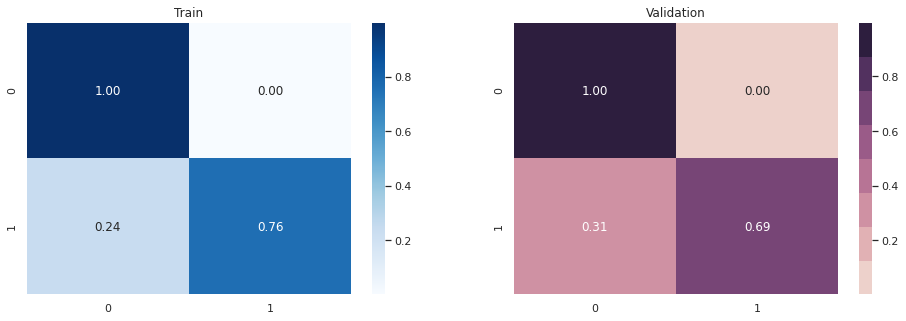

Fold: 2


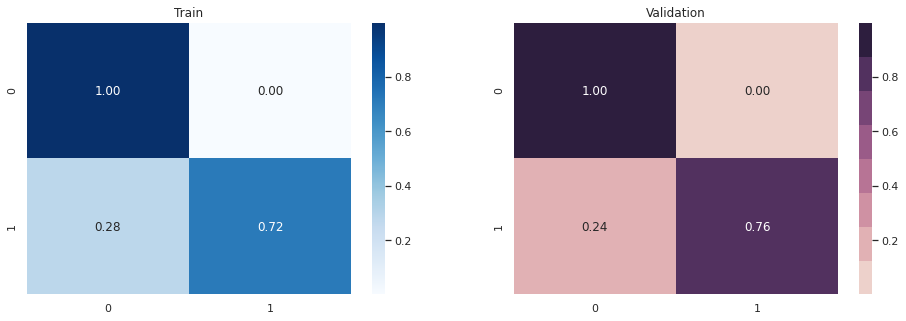

Fold: 3


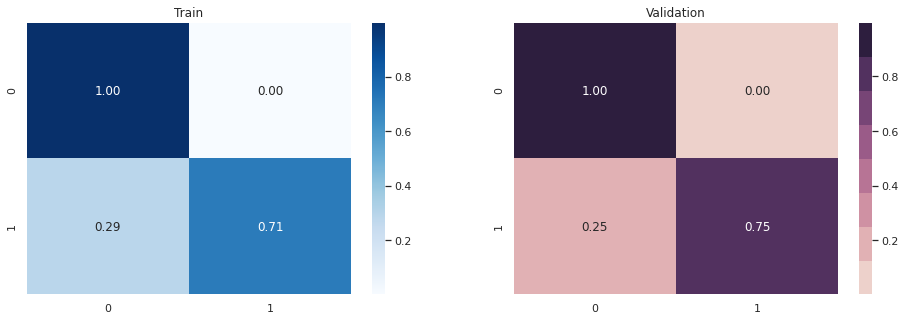

Fold: 4


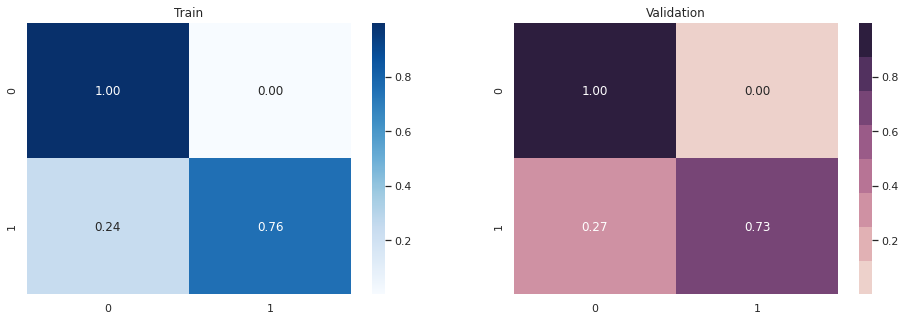

Fold: 5


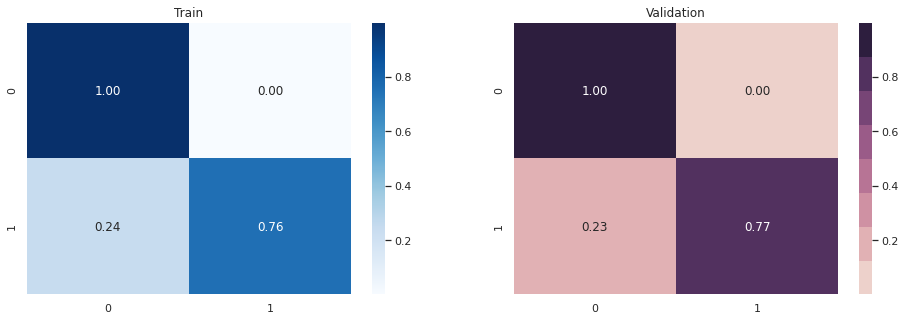

In [ ]:
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold[k_fold[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold[k_fold[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [ ]:
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")

Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.026298,0.027205,0.026861,0.025420,0.031038,0.020968
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.024143,0.028659,0.027308,0.021159,0.023200,0.020387
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.026319,0.026014,0.027064,0.025246,0.026393,0.026877
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.025570,0.028228,0.024198,0.027533,0.025167,0.022725
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.025251,0.027347,0.024393,0.024336,0.025665,0.024513
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.023150,0.022180,0.024127,0.029336,0.021804,0.018305
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.024616,0.026448,0.024622,0.022747,0.023539,0.025724
7,ISIC_0075663,female,35.0,torso,unknown,0,0.024764,0.025611,0.028479,0.023845,0.024388,0.021499
8,ISIC_0075914,male,30.0,torso,unknown,0,0.024565,0.022740,0.025492,0.027544,0.023889,0.023160
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.025824,0.020058,0.023222,0.036212,0.025881,0.023746


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.474622,0.033278,0.482150,0.879398,0.948172,0.030111
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.695983,0.915625,0.061041,0.991165,0.769475,0.742608
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.529669,0.739240,0.026006,0.871850,0.057713,0.953537
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.658799,0.991408,0.938392,0.901848,0.416769,0.045581
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.786936,0.977818,0.944424,0.979907,0.115410,0.917120
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.863677,0.408210,0.985093,0.970769,0.981811,0.972499
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.621742,0.979833,0.836716,0.973238,0.293366,0.025556
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.769451,0.948395,0.951994,0.961509,0.959486,0.025870
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.432850,0.035271,0.870313,0.200788,0.796863,0.261014
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.771751,0.977255,0.986727,0.029020,0.979430,0.886322


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.695983,0.915625,0.061041,0.991165,0.769475,0.742608
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.529669,0.739240,0.026006,0.871850,0.057713,0.953537
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.658799,0.991408,0.938392,0.901848,0.416769,0.045581
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.786936,0.977818,0.944424,0.979907,0.115410,0.917120
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.863677,0.408210,0.985093,0.970769,0.981811,0.972499
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.621742,0.979833,0.836716,0.973238,0.293366,0.025556
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.769451,0.948395,0.951994,0.961509,0.959486,0.025870
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.771751,0.977255,0.986727,0.029020,0.979430,0.886322
580,ISIC_0280912,male,70.0,torso,melanoma,1,0.727882,0.960292,0.802481,0.050846,0.887672,0.938120
607,ISIC_0286360,male,60.0,upper extremity,melanoma,1,0.649243,0.972972,0.955465,0.305501,0.990658,0.021618


Label/prediction distribution
Train positive labels: 584
Train positive predictions: 489
Train positive correct predictions: 487


# Make predictions (best)

In [16]:
model_path_list = glob.glob(MODEL_BASE_PATH + 'model' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

5 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_3.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_4.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_5.h5


In [17]:
test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


image_names = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_3.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_4.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/model_fold_5.h5


# Make predictions (last)

In [22]:
model_path_list = glob.glob(MODEL_BASE_PATH + 'last' + '*.h5')
n_models = len(model_path_list)
model_path_list.sort()

print(f'{n_models} Models to predict:')
print(*model_path_list, sep='\n')

5 Models to predict:
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/last_model_fold_1.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/last_model_fold_2.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/last_model_fold_3.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/last_model_fold_4.h5
/content/drive/My Drive/Colab Notebooks/Melanoma/Models/Files/37-resnet152/last_model_fold_5.h5


In [25]:
test_preds = np.zeros((NUM_TEST_IMAGES, 1))


for model_path in model_path_list:
    K.clear_session()
    print(model_path)
    model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))
    model.load_weights(model_path)
    
    test_preds += model.predict(test_dataset) / n_models


name_preds = dict(zip(image_names, test_preds.reshape(len(test_preds))))
test['target_last'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)

# Visualize test predictions

In [29]:
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last'] + 
             [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 96|10886
Test predictions (last) 105|10877
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
0,ISIC_0052060,male,70.0,NaN,0.025219,0.023549
1,ISIC_0052349,male,40.0,lower extremity,0.026199,0.024568
2,ISIC_0058510,female,55.0,torso,0.026046,0.024163
3,ISIC_0073313,female,50.0,torso,0.025463,0.024588
4,ISIC_0073502,female,45.0,lower extremity,0.024916,0.023521
5,ISIC_0074618,male,50.0,lower extremity,0.034172,0.033808
6,ISIC_0076801,male,45.0,upper extremity,0.024371,0.022630
7,ISIC_0077586,male,50.0,lower extremity,0.025837,0.024377
8,ISIC_0082004,female,45.0,torso,0.033957,0.031793
9,ISIC_0082785,male,65.0,lower extremity,0.028775,0.027330


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
24,ISIC_0112420,female,65.0,torso,0.867998,0.928958
296,ISIC_0391046,male,85.0,torso,0.926645,0.930339
403,ISIC_0481105,male,80.0,torso,0.979623,0.980744
471,ISIC_0539432,female,45.0,lower extremity,0.634847,0.659153
530,ISIC_0588352,male,60.0,lower extremity,0.566461,0.548458
552,ISIC_0606244,male,70.0,torso,0.832519,0.862294
596,ISIC_0637104,female,80.0,torso,0.704107,0.727520
1217,ISIC_1177164,male,40.0,palms/soles,0.755501,0.818141
1250,ISIC_1212424,male,55.0,torso,0.763767,0.724886
1408,ISIC_1364884,female,35.0,upper extremity,0.977738,0.981919


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last
24,ISIC_0112420,female,65.0,torso,0.867998,0.928958
202,ISIC_0299870,male,45.0,torso,0.470938,0.509675
296,ISIC_0391046,male,85.0,torso,0.926645,0.930339
403,ISIC_0481105,male,80.0,torso,0.979623,0.980744
471,ISIC_0539432,female,45.0,lower extremity,0.634847,0.659153
530,ISIC_0588352,male,60.0,lower extremity,0.566461,0.548458
552,ISIC_0606244,male,70.0,torso,0.832519,0.862294
596,ISIC_0637104,female,80.0,torso,0.704107,0.727520
860,ISIC_0867509,female,80.0,torso,0.489980,0.543363
1217,ISIC_1177164,male,40.0,palms/soles,0.755501,0.818141


# Test set predictions (best)

In [20]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission.to_csv(SUBMISSION_PATH, index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.025219
1,ISIC_0052349,0.026199
2,ISIC_0058510,0.026046
3,ISIC_0073313,0.025463
4,ISIC_0073502,0.024916
5,ISIC_0074618,0.034172
6,ISIC_0076801,0.024371
7,ISIC_0077586,0.025837
8,ISIC_0082004,0.033957
9,ISIC_0082785,0.028775


,target
count,10982.000000
mean,0.040367
std,0.077351
min,0.018630
25%,0.025694
50%,0.026805
75%,0.028357
max,0.986137


# Test set predictions (last)

In [27]:
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target_last']
submission.to_csv(SUBMISSION_LAST_PATH, index=False)
display(submission.head(10))
display(submission.describe())

,image_name,target
0,ISIC_0052060,0.023549
1,ISIC_0052349,0.024568
2,ISIC_0058510,0.024163
3,ISIC_0073313,0.024588
4,ISIC_0073502,0.023521
5,ISIC_0074618,0.033808
6,ISIC_0076801,0.022630
7,ISIC_0077586,0.024377
8,ISIC_0082004,0.031793
9,ISIC_0082785,0.027330


,target
count,10982.000000
mean,0.040024
std,0.081358
min,0.017502
25%,0.024226
50%,0.025295
75%,0.026844
max,0.989452
